In [1]:
library(gprofiler2)
library(dplyr)

library(tidyverse)

g2g_cluster <- read.table('data/genes2genes_cluster_en_psyad_sfari.txt', header = T,sep='\t',)

genes_sim <- read.table('data/genes2genes_similarity_psyad_sfari.txt',sep='\t',header = T)

long_data <- g2g_cluster %>%
  pivot_longer(cols = everything(), names_to = "Column", values_to = "Gene") %>%
  filter(Gene != "")
long_data <- as.data.frame(long_data)
rownames(long_data) <- long_data$Gene

#for 
genes_sim$cluster <- long_data[genes_sim$Gene,'Column']
#genes_sim <- subset(genes_sim,cluster%in%names(table(genes_sim$cluster)>= 20)[table(genes_sim$cluster)>= 20])


genes_sim <- within(genes_sim,{
    Pattern=''
    Pattern[alignment_similarity_percentage <= 0.3 & l2fc >= log2(2)] <- 'EN up'
    Pattern[alignment_similarity_percentage <= 0.3 & l2fc <= -log2(2)] <- 'OSN up'
    Pattern[alignment_similarity_percentage >= 0.6 ] <- 'Matched'
    #Pattern[alignment_similarity_percentage >= 0.3 & alignment_similarity_percentage <= 0.7 & l2fc > 1] <- 'OSN slight up'
    #Pattern[alignment_similarity_percentage >= 0.3 & alignment_similarity_percentage <= 0.7 & l2fc < -1] <- 'EN slight up'
    #Pattern[alignment_similarity_percentage >= 0.3 & alignment_similarity_percentage <= 0.7 & (l2fc > -1&l2fc < 1)] <- 'EN slight up'
    Pattern[is.na(Pattern)] <- 'Medium matched'

})



Warning message:
“package ‘gprofiler2’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflict

In [2]:


pattern <- list( "IIIDIDIDIDIIIDDDMMMMDD" = 'Late convergence',
 'MMMMMMMMMIMMMD' = 'Match',
'IIIDIMMMMMMMMWMDD' = '2',
 'IIIDIDIDIDIIIIDMMMWWWWD' = '3',
 'IIIIIMMDDMMMMMMDDD' = '4',
 'IIIDIDIDIDIIIIIIIDDDDDDDDD' = 'Mismatch',
 'IIIDMIDDDMMMMIIIMDDD' = '6',
 'IDDDDDMMMIIDMMIMVVM' = '7',
 'IIIDIMDDMMMMMMMMD' = 'Middle convergence',
 'IIIIMVVVMVMWMMDDDDDDD' = '9',
 'IIIIIIMMMDDDDMMMWMD' = '10',
 'MMMMMVVMIIIIDIDDDDDD' = '11')

genes_sim$cluster_pat=unlist(pattern[genes_sim$cluster])
genes_sim$cluster_pattern=paste0(genes_sim$cluster_pat,':',genes_sim$cluster)
genes_sim$FC  <- ifelse(genes_sim$l2fc >0,'EN up','OSN up')
genes_sim$pattern_cluster <- ifelse(!genes_sim$cluster_pat%in%c('Mismatch'),
                                    genes_sim$cluster_pattern,
                                    paste0(genes_sim$cluster_pattern, ' (',genes_sim$FC, ')'))

pdf 
  2

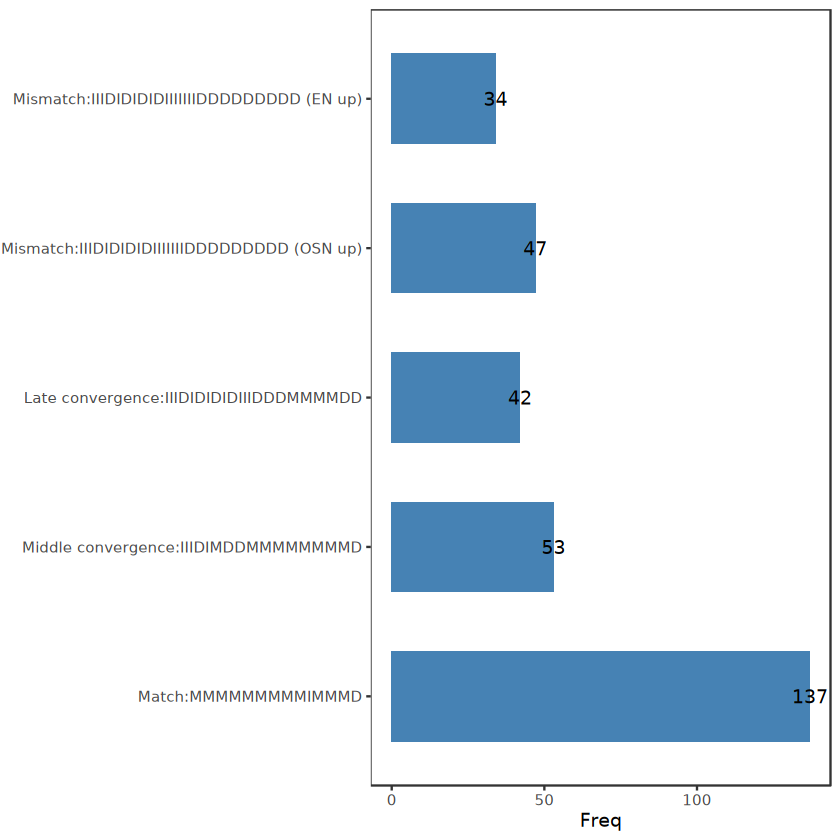

In [3]:
cat_sel <- c('Match:MMMMMMMMMIMMMD', 'Middle convergence:IIIDIMDDMMMMMMMMD','Late convergence:IIIDIDIDIDIIIDDDMMMMDD', 
             'Mismatch:IIIDIDIDIDIIIIIIIDDDDDDDDD (OSN up)','Mismatch:IIIDIDIDIDIIIIIIIDDDDDDDDD (EN up)' )

df_cat <- as.data.frame(table(genes_sim$pattern_cluster))
df_cat$Cat <- ifelse(df_cat$Freq >=30,as.character(df_cat$Var1),'Others')


ggplot(subset(df_cat,Freq >=30),aes(x = factor(Cat,levels = cat_sel), y=Freq)) +
  geom_bar(stat='identity', fill='steelblue',width=0.6) +
geom_text(aes(label=Freq))+xlab('')+coord_flip()+theme_bw()+theme( panel.grid.major = element_blank(),  # Remove major grid lines
  panel.grid.minor = element_blank() )

dev.print(pdf, file='./figures/de_xx.pdf',height=3.5, width=6)


genes_sim <- subset(genes_sim,pattern_cluster%in%names(table(genes_sim$pattern_cluster)>= 50)[table(genes_sim$pattern_cluster)>= 30])
#save(genes_sim, file='./data/genes_sim.RData')

In [4]:
232/351

[1] 0.6609687

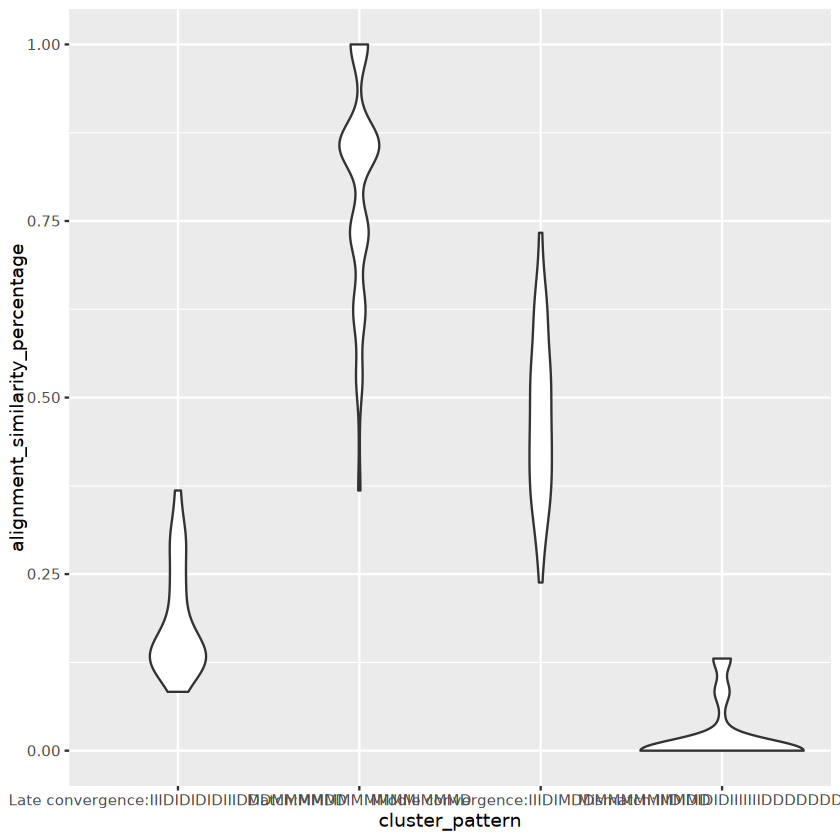

In [5]:
ggplot(genes_sim, aes(x=cluster_pattern,y=alignment_similarity_percentage))+
geom_violin()

Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_ydensity()`).”


pdf 
  2

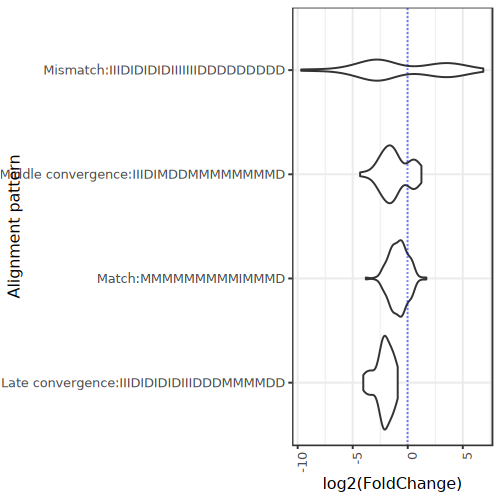

In [14]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)

ggplot(genes_sim, aes(x=cluster_pattern,y=l2fc))+
geom_violin()+theme_bw()+
theme(axis.text.x=element_text(angle=90, hjust=1,vjust=1), legend.position = 'top')+
#geom_hline(yintercept = 0)+
geom_hline(yintercept = 0, linetype = "dotted", colour= 'blue')+coord_flip()+xlab('Alignment pattern')+ylab('log2(FoldChange)')

dev.print(pdf, file='./figures/log2FC_genes2genes.pdf',width= 6,height= 3)


In [166]:
goterms_x <- gost(split(genes_sim$Gene,genes_sim$pattern_cluster ), source='GO:BP' ,
                correction_method = "fdr"#,user_threshold=0.1,significant=F#,evcodes=T
                 )$result %>%subset(term_size < 2000)
# goterms_sim <- gost(split(genes_sim$Gene,genes_sim$Pattern ), source='GO:BP' ,
#                 correction_method = "fdr"#,user_threshold=0.1,significant=F#,evcodes=T
#                  )$result %>%subset(term_size < 2000)
# goterms_c <- gost(split(genes_sim$Gene,genes_sim$cluster_pattern ), source='GO:BP' ,
#                 correction_method = "fdr"#,user_threshold=0.1,significant=F#,evcodes=T
#                  )$result %>%subset(term_size < 2000)

pdf 
  2

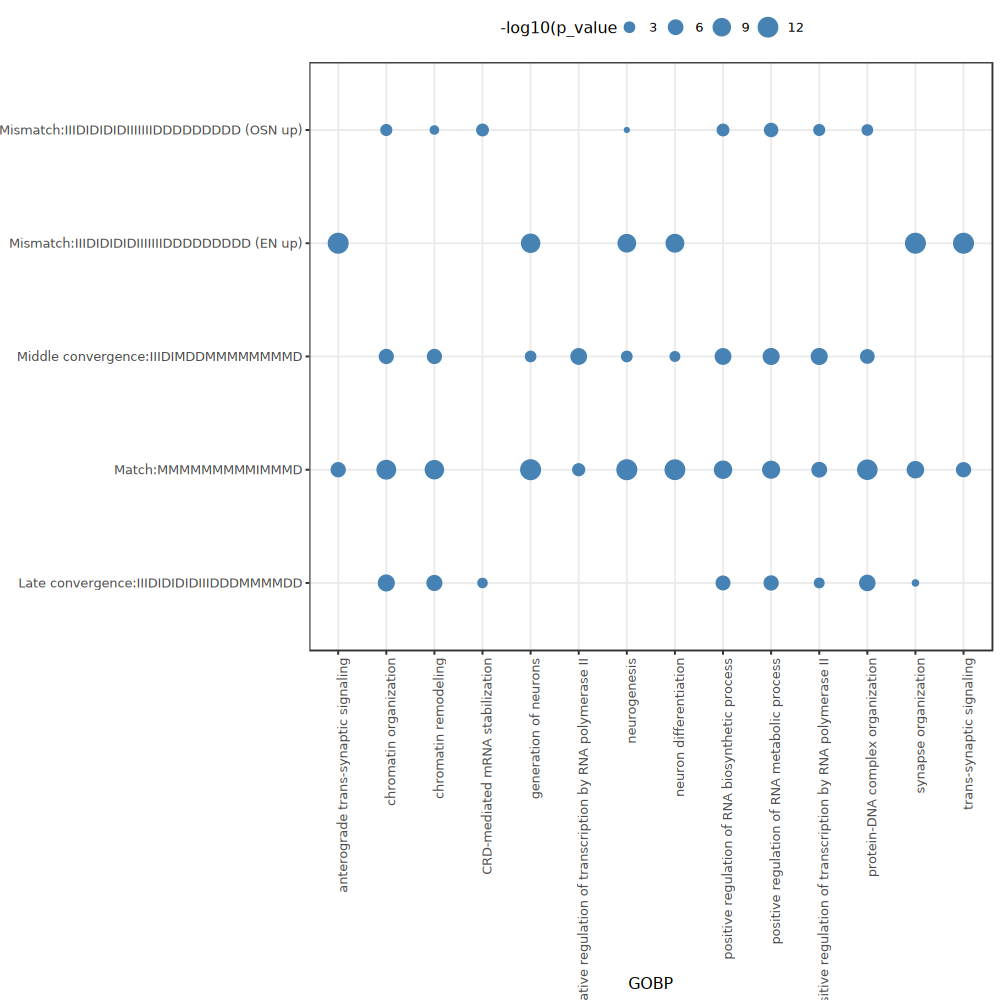

In [167]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)


library(dplyr)
goterms_x$p_value  <- goterms_x$p_value+c(1:nrow(goterms_x))/(0000000.1/min(goterms_x$p_value))
pp_sig <- goterms_x%>%group_by(query)%>%top_n(3, -p_value)
gobps_brain_sig <- subset(goterms_x, term_name%in%pp_sig$term_name)%>%subset(p_value < 0.05)
ggplot(gobps_brain_sig, aes(x=query,y=term_name,size=-log10(p_value)))+
geom_point(color='steelblue')+theme_bw()+coord_flip()+
theme(axis.text.x=element_text(angle=90, hjust=1,vjust=1), legend.position = 'top')+labs(x='',y='GOBP')


dev.print(pdf, file='./figures/top_xx.pdf',height=10, width=10)

In [168]:
library(stringr)
library(gprofiler2)
library(rrvgo)
library(ggplot2)

get_bp_enrichr_reducedTerms <- function(go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont=c('BP'),
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")

  return(reducedTerms)
  
}

pp_sigx <- gobps_brain_sig
pp_sigx <- pp_sigx[order(-pp_sigx$p_value),]
pp_sigx <- pp_sigx[ !duplicated(pp_sigx$term_id),]
pp_sigx_reducedTerms <- get_bp_enrichr_reducedTerms(pp_sigx)
rownames(pp_sigx_reducedTerms) <- pp_sigx_reducedTerms$term



preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



In [169]:
library(reshape2)
dpp <- dcast(gobps_brain_sig[,c("term_name","query","p_value")],query~term_name)
rownames(dpp) <- dpp$query
dpp <- dpp[,-1]
dpp <- -log10(dpp)


#trend

Using p_value as value column: use value.var to override.



In [170]:
#pp_sigx_reducedTerms

In [171]:
library(circlize)

library(RColorBrewer)
options(repr.plot.width = 25, repr.plot.height = 15, repr.plot.res = 100)
go_color=brewer.pal(n = 12, name = "Set3")[1:length(unique(pp_sigx_reducedTerms$parentTerm))]
names(go_color) <- unique(pp_sigx_reducedTerms$parentTerm)

library(ComplexHeatmap)

dpp <- dpp[rev(cat_sel),unique(gobps_brain_sig$term_name)]

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

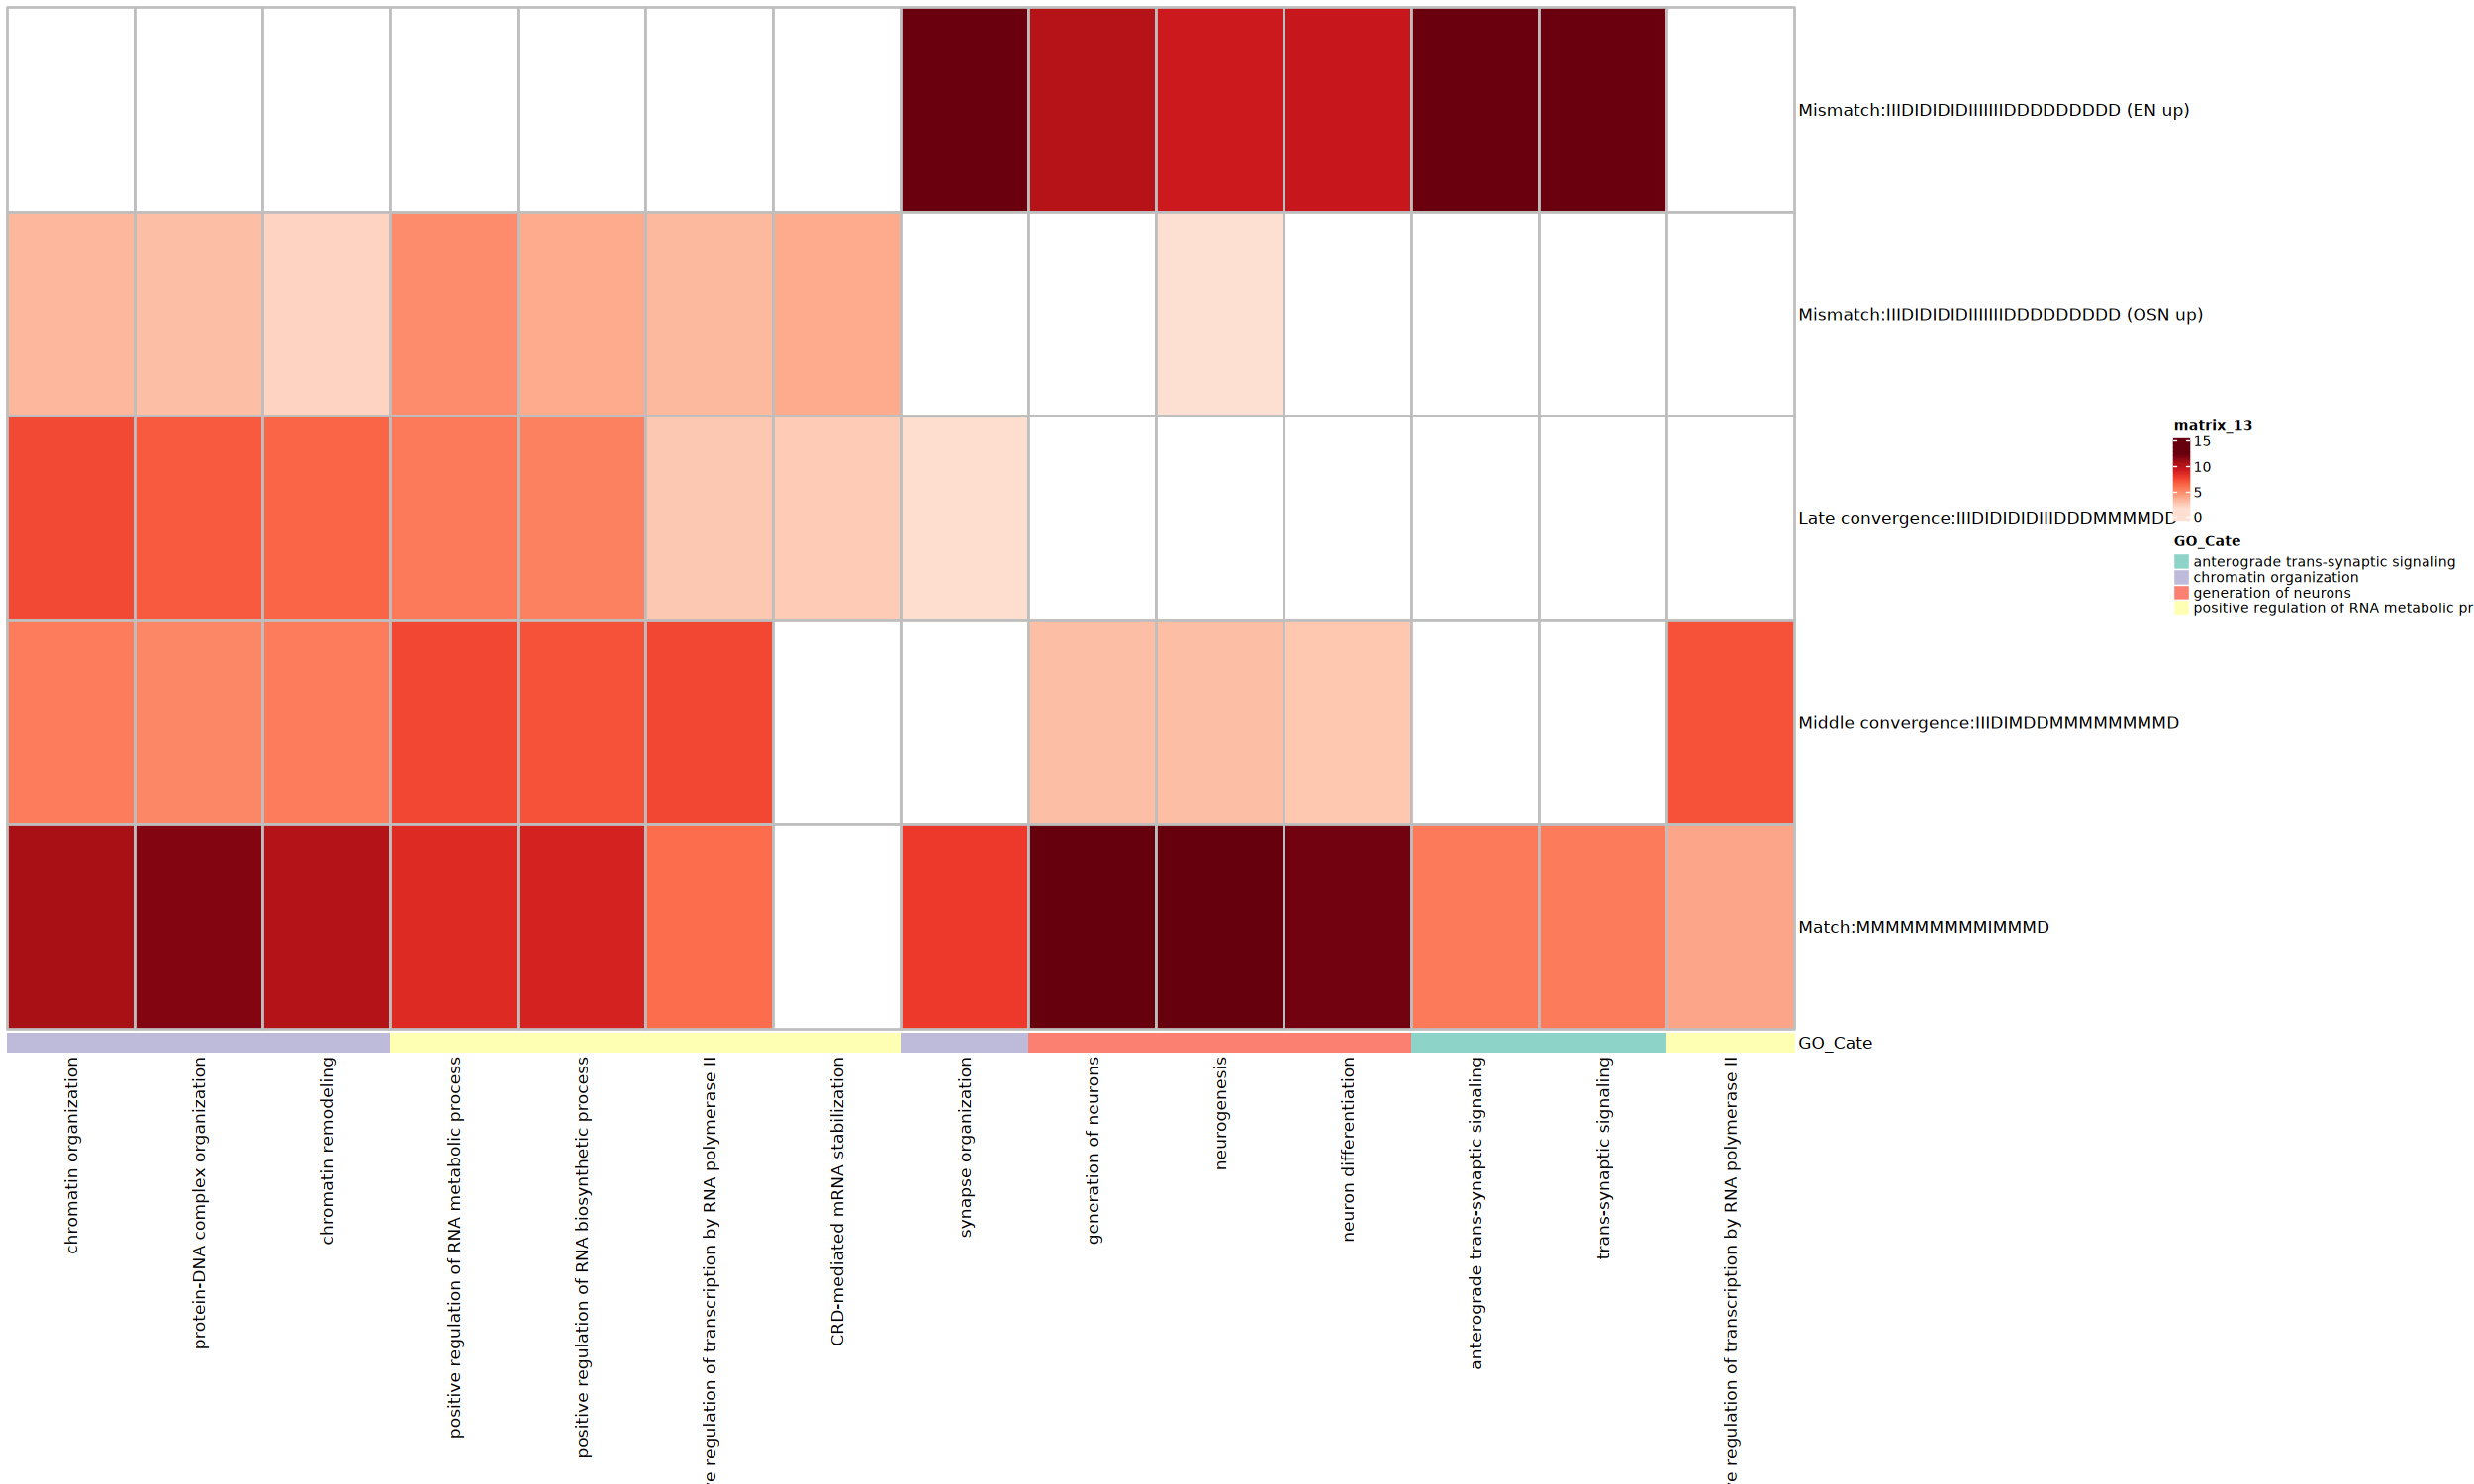

In [172]:
#dpp
ht_list <- Heatmap(
  dpp,
    na_col = "white",
    col                          = colorRamp2(seq(from=min(dpp,na.rm = T),to=max(dpp,na.rm = T),length=8),
                                              brewer.pal(9, "Reds")[-1]),
    cluster_columns              = F,
    cluster_rows                 = F,
    show_row_names               = T,
    show_column_names            = T,
    row_names_max_width = unit(15, "cm"),
    column_names_max_height  = unit(15, "cm"),
    show_row_dend = F,
    bottom_annotation = HeatmapAnnotation(
               GO_Cate=pp_sigx_reducedTerms[colnames(dpp),'parentTerm'],
 col=list(GO_Cate=go_color)
    ),
    rect_gp = gpar(col = "grey", lwd = 2)#,
    #left_annotation=rowAnnotation(
        # pattern=rownames(dpp),
        #OSN_pattern = trend[rownames(dpp),'OSN'],
       # EN_pattern = trend[rownames(dpp),'EN']#,
        #col = list(OSN_pattern = oe_color,
        #          EN_pattern=en_color)
    #)#,
    #row_split = trend[rownames(dpp),'OSN']
   # row_split = c(rep('down',4), rep('trans_up',4),'trans_down',rep('up',4))
)

draw(ht_list, merge_legend = TRUE, heatmap_legend_side = "right", 
     annotation_legend_side = "right")

dev.print(pdf, file='./figures/go_genes2genes.pdf', height=8, width=14)

In [174]:
goterms_xx <- gost(split(genes_sim$Gene,genes_sim$pattern_cluster ), source='GO:BP' ,
                correction_method = "fdr",evcodes=T
                 )$result %>%subset(term_size < 2000)

In [176]:
subset(goterms_xx,query=='Match:MMMMMMMMMIMMMD')

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,evidence_codes,intersection
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>,<chr>
407,Match:MMMMMMMMMIMMMD,TRUE,3.037957e-13,1514,135,41,0.3037037,0.02708058,GO:0048699,GO:BP,generation of neurons,21031,13381,GO:0022008,"ISS,ISS IEA,ISS,IDA IMP ISS IBA IEA,IEA,IDA,IEA,ISS,ISS IBA,IMP ISS TAS,ISS,ISS IEA,ISS,IMP,IEA,IEA,IEA,ISS,IEA,IDA ISS,IEA,IBA,IMP,IEA,ISS IBA IEA,IEA,ISS IEA,ISS IEA,IEA,IDA ISS,ISS IBA IEA,ISS IEA,IEA,IMP ISS IEA,IGI,ISS IBA,IMP,TAS,IBA,IDA,IEA","CEP290,RORB,PTEN,BCL11A,GIGYF2,RIMS2,NCOA1,AHI1,TANC2,CAMK2B,TCF4,DLG4,DIP2A,ACTL6B,MECP2,RORA,RERE,ANK3,CUL4B,FMR1,SHANK3,NCKAP1,YWHAG,BRAF,BRSK2,PTPN11,STXBP1,NF1,SYNGAP1,MACF1,MYCBP2,NFIB,WASF1,NOVA2,SOX5,PAK1,USP9X,VPS13B,CDH2,UNC13A,PPP3CA"
409,Match:MMMMMMMMMIMMMD,TRUE,3.037957e-13,1742,135,44,0.3259259,0.02525832,GO:0022008,GO:BP,neurogenesis,21031,6799,GO:00073....,"ISS,ISS IEA,ISS,IDA IMP ISS IBA IEA,IEA,IDA,IEA,ISS,ISS IBA,IMP ISS TAS,ISS,ISS,ISS IEA,ISS,IMP,IEA,ISS IEA,IEA,IEA,ISS,IEA,IDA ISS,IEA,IBA,IMP,IEA,ISS IBA IEA,IEA,ISS IEA,ISS IEA,IEA,IDA ISS,ISS IBA IEA,ISS IEA,IGI ISS,IEA,IMP ISS IEA,IGI,ISS IBA,IMP,TAS,ISS IBA IEA,IDA,IEA","CEP290,RORB,PTEN,BCL11A,GIGYF2,RIMS2,NCOA1,AHI1,TANC2,CAMK2B,TCF4,SOX6,DLG4,DIP2A,ACTL6B,MECP2,MBOAT7,RORA,RERE,ANK3,CUL4B,FMR1,SHANK3,NCKAP1,YWHAG,BRAF,BRSK2,PTPN11,STXBP1,NF1,SYNGAP1,MACF1,MYCBP2,NFIB,SKI,WASF1,NOVA2,SOX5,PAK1,USP9X,VPS13B,CDH2,UNC13A,PPP3CA"
418,Match:MMMMMMMMMIMMMD,TRUE,7.585360e-13,1431,135,39,0.2888889,0.02725367,GO:0030182,GO:BP,neuron differentiation,21031,6936,GO:00301....,"ISS,ISS IEA,ISS,IDA IMP ISS IBA IEA,IEA,IDA,IEA,ISS,ISS IBA,ISS TAS,ISS,ISS IEA,ISS,IMP,IEA,IEA,IEA,ISS,IEA,IDA ISS,IEA,IBA,IMP,IEA,ISS IBA IEA,IEA,ISS IEA,IEA,IDA ISS,ISS IBA IEA,ISS IEA,IEA,IMP ISS IEA,ISS IBA,IMP,TAS,IBA,IDA,IEA","CEP290,RORB,PTEN,BCL11A,GIGYF2,RIMS2,NCOA1,AHI1,TANC2,CAMK2B,TCF4,DLG4,DIP2A,ACTL6B,MECP2,RORA,RERE,ANK3,CUL4B,FMR1,SHANK3,NCKAP1,YWHAG,BRAF,BRSK2,PTPN11,STXBP1,SYNGAP1,MACF1,MYCBP2,NFIB,WASF1,NOVA2,PAK1,USP9X,VPS13B,CDH2,UNC13A,PPP3CA"
423,Match:MMMMMMMMMIMMMD,TRUE,1.466917e-12,655,135,27,0.2000000,0.04122137,GO:0048812,GO:BP,neuron projection morphogenesis,21031,13483,GO:00311....,"ISS,IMP ISS IEA,IDA,ISS IBA,ISS,ISS IEA,ISS,IEA,IEA,ISS,IEA,IBA,IEA,ISS IBA IEA,IEA,ISS IEA,IEA,IDA ISS,ISS IBA IEA,ISS IEA,IEA,ISS IEA,ISS IBA,IMP,IBA,IDA,IEA","PTEN,BCL11A,RIMS2,TANC2,CAMK2B,DLG4,DIP2A,MECP2,RERE,ANK3,SHANK3,NCKAP1,BRAF,BRSK2,PTPN11,STXBP1,SYNGAP1,MACF1,MYCBP2,NFIB,WASF1,NOVA2,PAK1,USP9X,CDH2,UNC13A,PPP3CA"
425,Match:MMMMMMMMMIMMMD,TRUE,2.004688e-12,785,135,29,0.2148148,0.03694268,GO:0032989,GO:BP,cellular anatomical entity morphogenesis,21031,8249,GO:0009653,"ISS,IMP ISS IEA,IDA,ISS IBA,ISS,ISS IEA,ISS,IEA,IEA,ISS,IEA,IBA,IEA,ISS IBA IEA,IEA,ISS IEA,IEA,IDA ISS,ISS IBA IEA,ISS IEA,IMP IEA,ISS IEA,ISS IBA,IMP,IMP IEA,ISS IEA,IBA,IDA,IEA","PTEN,BCL11A,RIMS2,TANC2,CAMK2B,DLG4,DIP2A,MECP2,RERE,ANK3,SHANK3,NCKAP1,BRAF,BRSK2,PTPN11,STXBP1,SYNGAP1,MACF1,MYCBP2,NFIB,WASF1,NOVA2,PAK1,USP9X,TTN,VPS13B,CDH2,UNC13A,PPP3CA"
426,Match:MMMMMMMMMIMMMD,TRUE,2.116460e-12,915,135,31,0.2296296,0.03387978,GO:0071824,GO:BP,protein-DNA complex organization,21031,17433,GO:0043933,"IEA,IDA IEA,IDA IEA,IMP IBA IEA,IMP,IDA IEA,IEA,ISS,TAS NAS IEA,IDA IEA,IDA NAS IEA,IMP IEA,IEA,IMP IEA,IEA,IEA,IDA IEA,IDA IBA IEA,IMP ISS IEA,IBA IEA,IPI,IEA,IDA IMP IBA IEA,IDA IEA,IEA,IDA IMP IEA,IDA IMP ISS IBA IEA,IMP,IEA,IDA,IEA","SETD1B,PHF8,WDR5,CHD1,TRIP12,DYRK1A,NCOA1,TCF4,SMARCA2,KDM2B,ACTL6B,MECP2,ZNF462,SETD2,KANSL1,RERE,SETD1A,RLIM,PHF2,KDM5C,TAF4,NSD1,CHD3,EHMT1,ASH1L,HDAC4,ATRX,POGZ,PHF21A,PAK1,HUWE1"
427,Match:MMMMMMMMMIMMMD,TRUE,2.238998e-12,671,135,27,0.2000000,0.04023845,GO:0120039,GO:BP,plasma membrane bounded cell projection morphogenesis,21031,20036,GO:0048858,"ISS,IMP ISS IEA,IDA,ISS IBA,ISS,ISS IEA,ISS,IEA,IEA,ISS,IEA,IBA,IEA,ISS

pdf 
  2

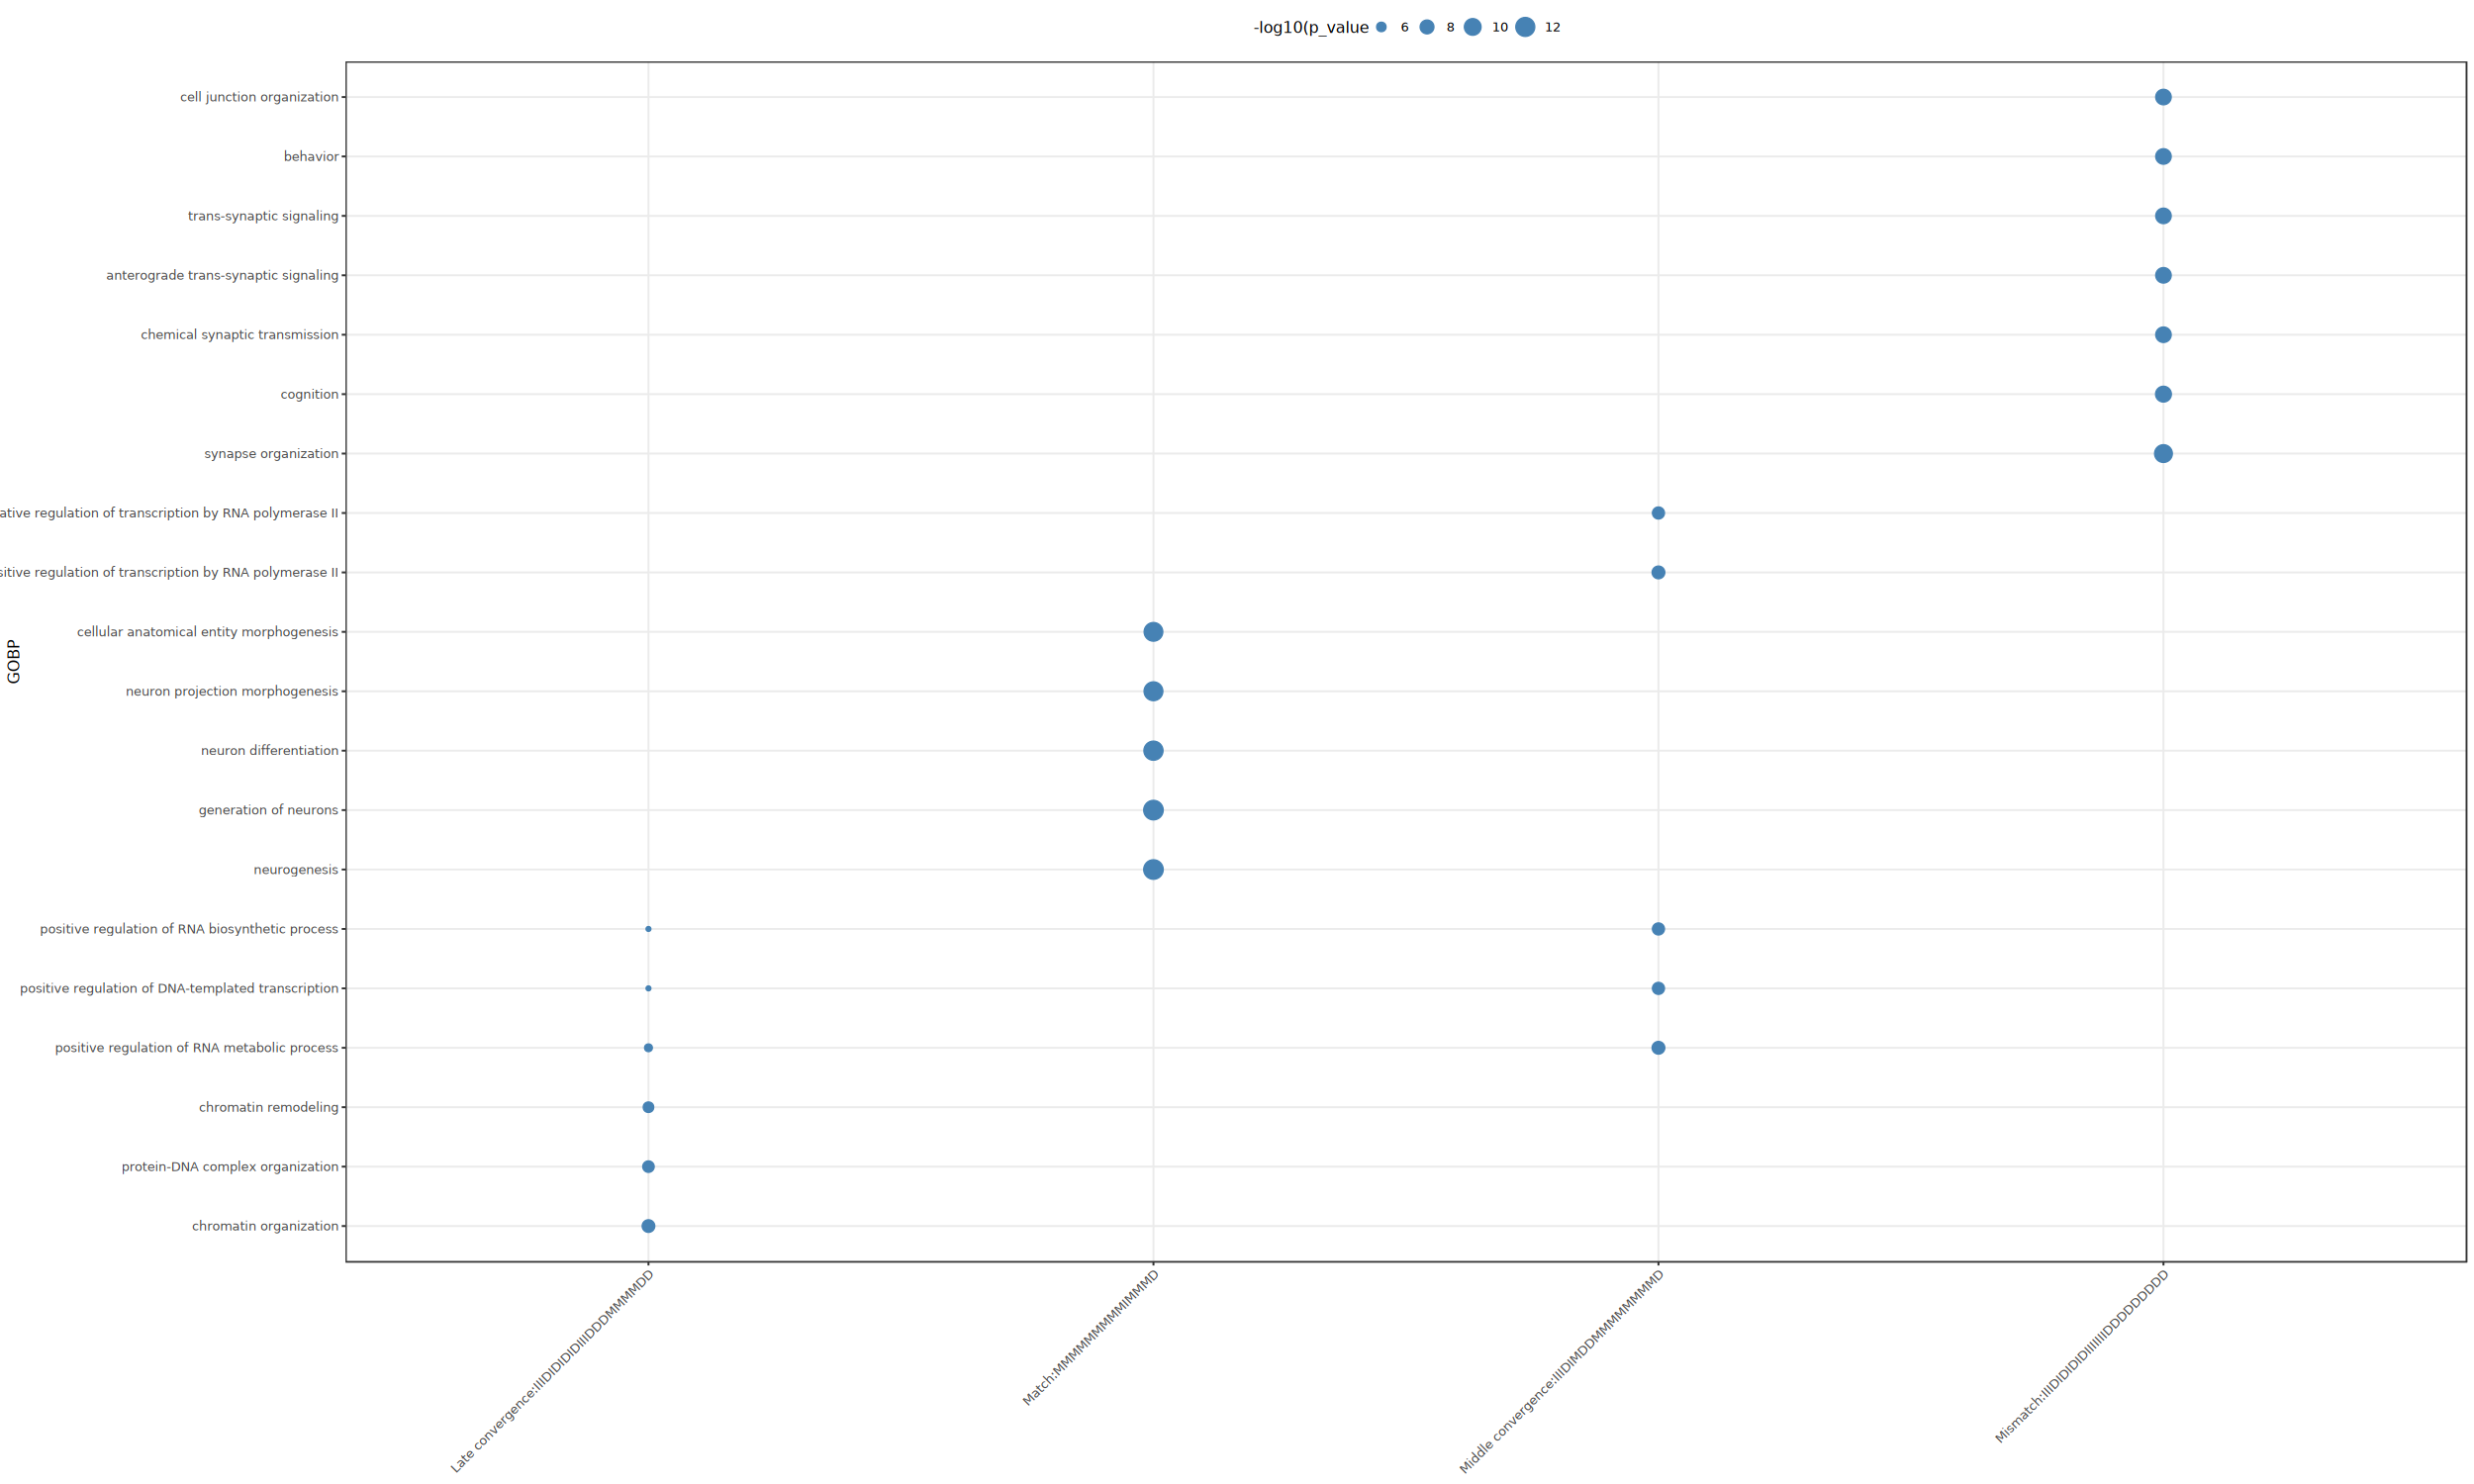

In [173]:
gobps_brain_sig <- subset(goterms_c, p_value < 0.01)

gobps_brain_sig <- gobps_brain_sig%>%group_by(query)%>%top_n(5, -p_value)
gobps_brain_sig$term_name <- factor(gobps_brain_sig$term_name, levels=unique(gobps_brain_sig$term_name))
ggplot(gobps_brain_sig, aes(x=query,y=term_name,size=-log10(p_value)))+
geom_point(color='steelblue')+theme_bw()+
theme(axis.text.x=element_text(angle=45, hjust=1,vjust=1), legend.position = 'top')+labs(x='',y='GOBP')
dev.print(pdf, file='./figures/top_xxx.pdf',height=8, width=8)
#dev.print(pdf, file='./figures/top_xx.pdf',height=3.5, width=4.5)

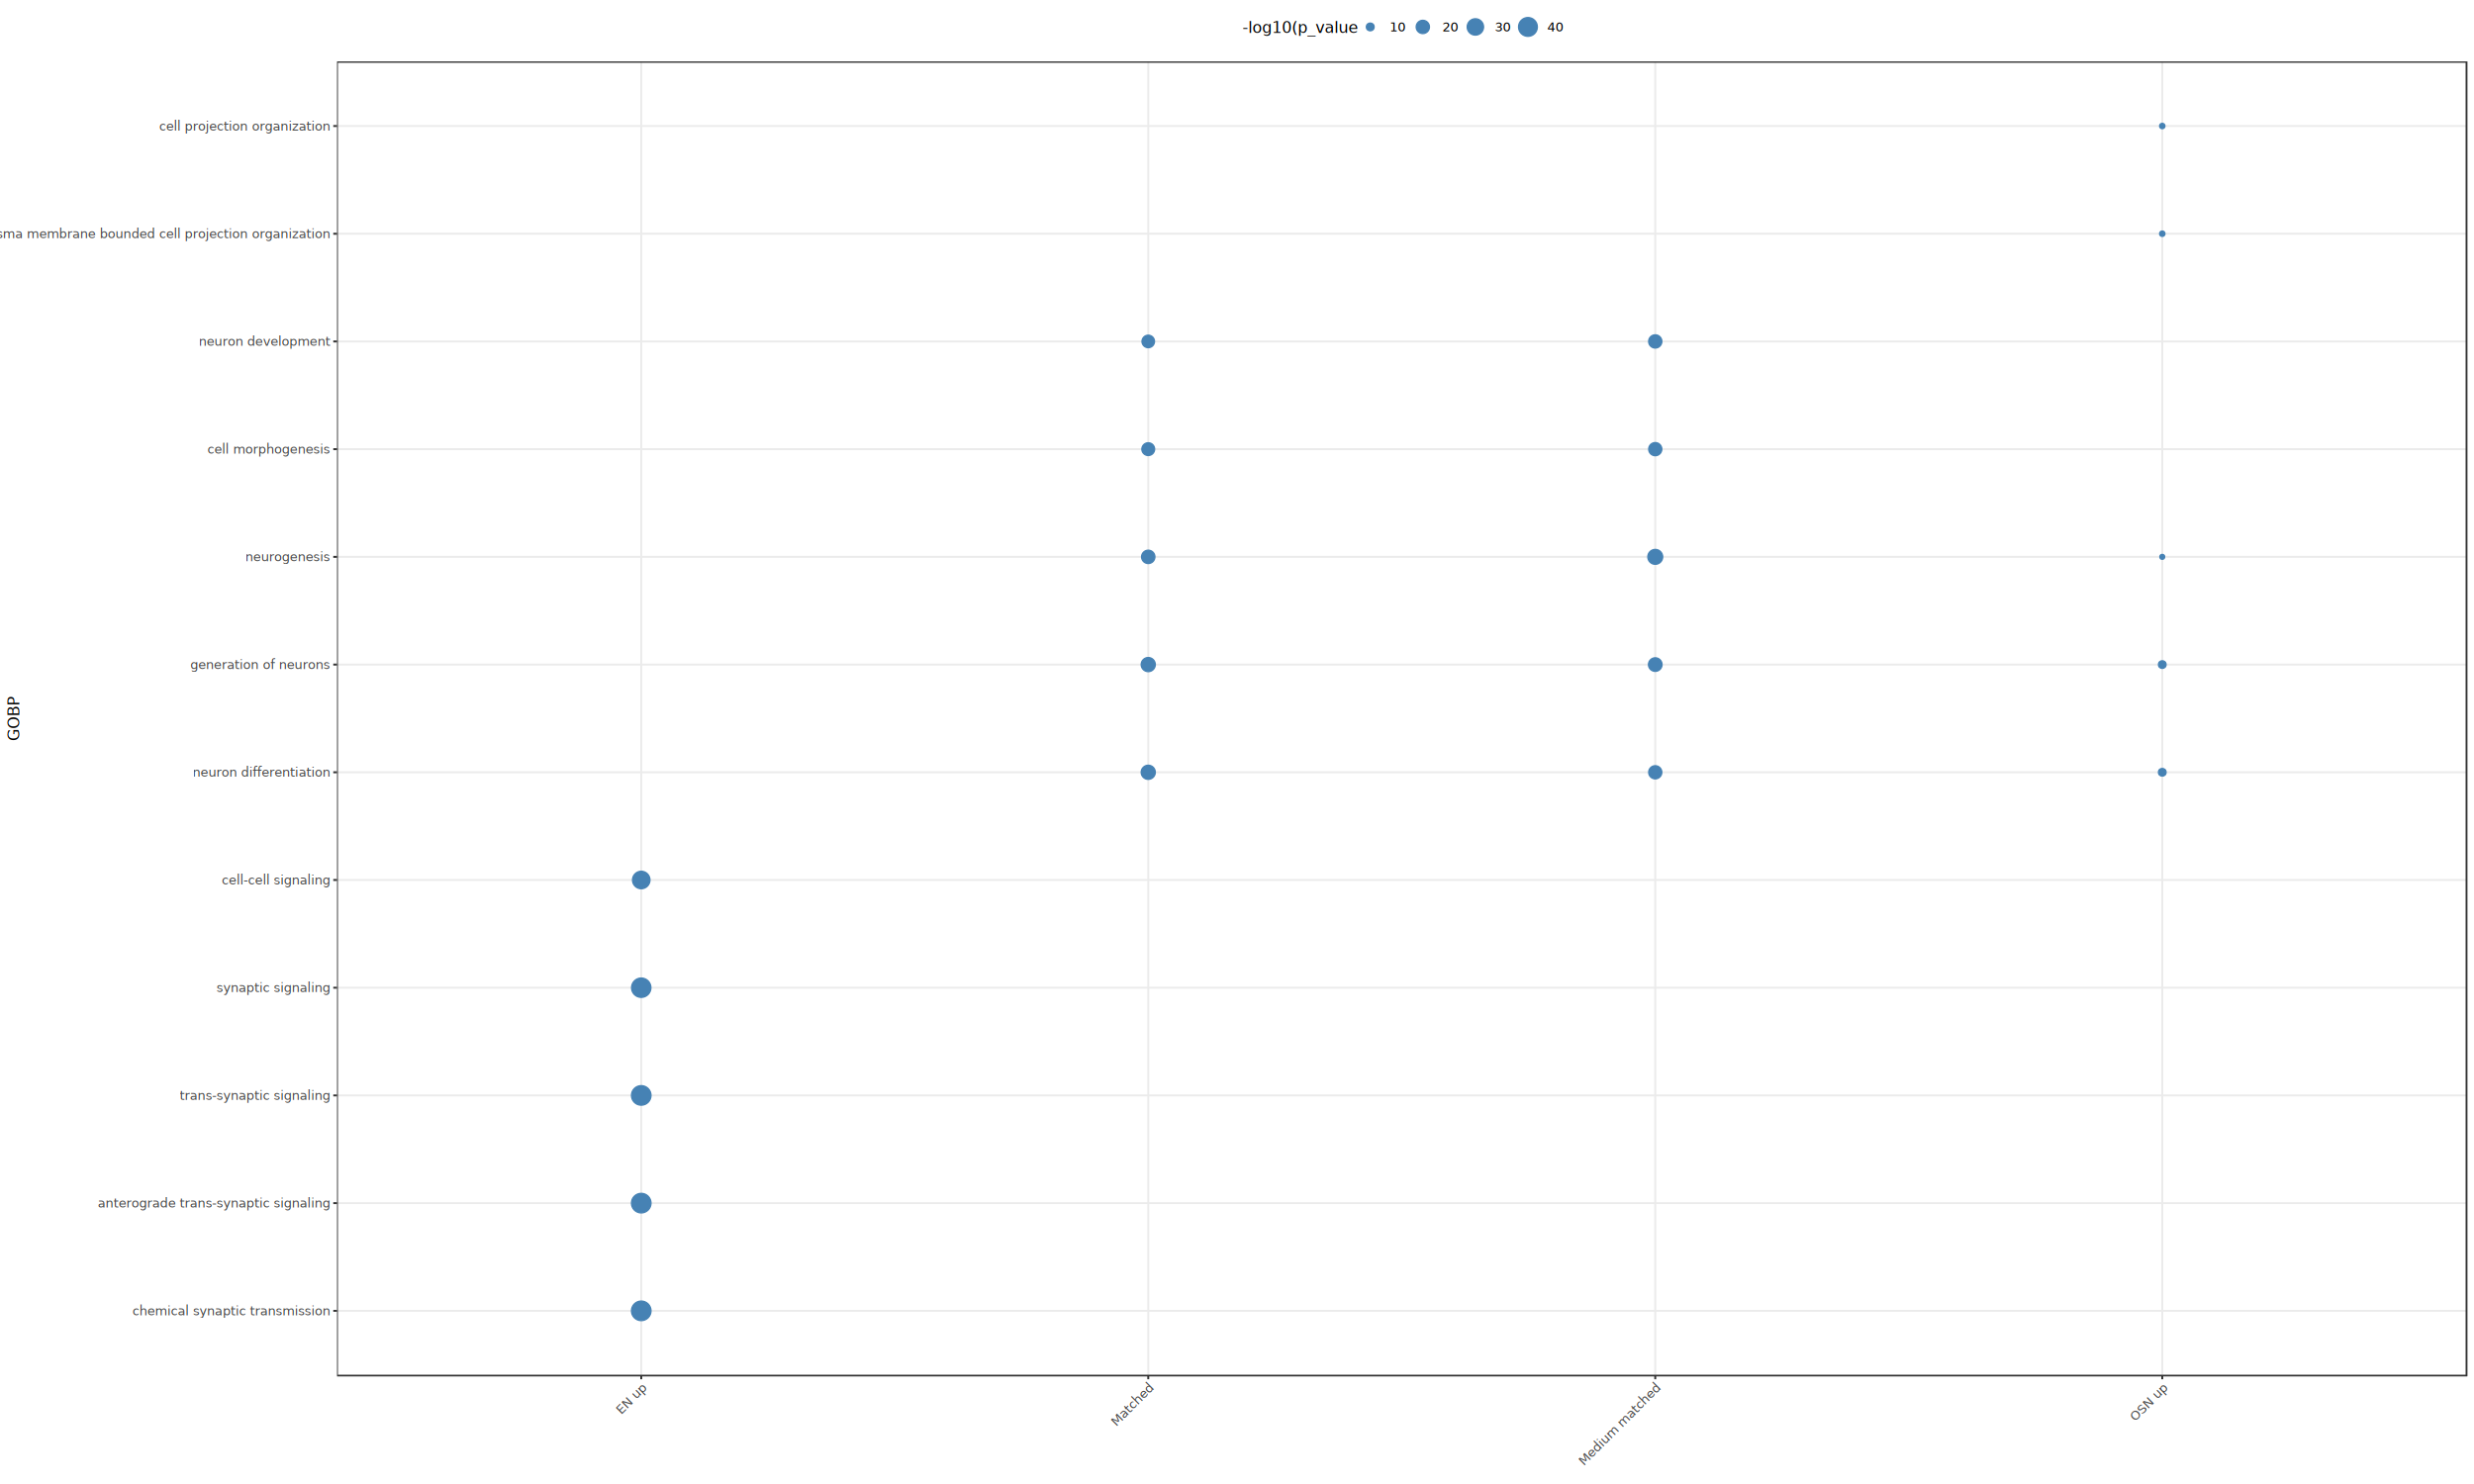

In [73]:
gobps_brain_sig <- subset(goterms_sim, p_value < 0.05)

gobps_brain_sig <- gobps_brain_sig%>%group_by(query)%>%top_n(5, -p_value)
gobps_brain_sig$term_name <- factor(gobps_brain_sig$term_name, levels=unique(gobps_brain_sig$term_name))
ggplot(gobps_brain_sig, aes(x=query,y=term_name,size=-log10(p_value)))+
geom_point(color='steelblue')+theme_bw()+
theme(axis.text.x=element_text(angle=45, hjust=1,vjust=1), legend.position = 'top')+labs(x='',y='GOBP')